# Text Classifier on Pet data

## Intro

This notebook is intended to build a binary text classifier based on the data provided by Trupanion. The data used including a brief description for each item, the diagnosis and whether the item is flagged as preventive. There are 11000 observations in total and 1000 of them do not have labels on them. <br>

For this problem, I only consider two columns -- ItemDescription and PreventiveFlag. The column of Diagnosis may also be useful to determine whether an item should be flagged or not. However, I will not explore it here.

In [75]:
# Load data

import pandas as pd
    
data = pd.read_csv('p2_data.csv', encoding = 'ISO-8859-1')
data.head()

,id,ItemDescription,Diagnosis,PreventiveFlag
0,1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
1,2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
2,3,Jafar: Fecal Smears,Stomach Issues,0.0
3,4,Jafar: metronidazole 50mg,Stomach Issues,0.0
4,5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


## Explore the data
To see the distribution of the data, I used a bar plot. From the plot, we can see that the data is imbalanced with about 93% being 0.0. 

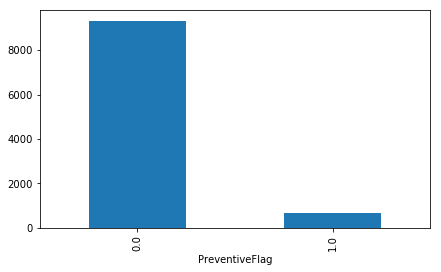

PreventiveFlag
0.0    9322
1.0     678
Name: ItemDescription, dtype: int64


In [76]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (7, 4))
counts = data.groupby('PreventiveFlag').ItemDescription.count()
counts.plot.bar(ylim = 0)
plt.show()
print counts

## Data Preparation and Model Training

The classifiers and learning algorithms can not directly process the text documents in their original form. Therefore, the first thing we need to do is to convert the texts into numerical feature vectors. The vectorization of features are done using Bag of Words model, a model that take the presence (and often the frequency) of words into consideration and TF-IDF, whose value represents the importance of a word to a document in a corpus. <br>

One of the simplest model for a text classifier is Navie Bayes(NB), so I tried it first as a starter. <br>

To make it easier, I built a pipeline for all the processes discussed. <br>

In [77]:
from sklearn.model_selection import train_test_split

# Randomly separate training and testing data

x_train, x_test, y_train, y_test = train_test_split(data['ItemDescription'][: 10000], data['PreventiveFlag'][: 10000], 
                                                    test_size = 0.2, random_state = 0)

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Build a pipeline for data preparation and model training

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(x_train, y_train)

In [79]:
# Make Predictions

import numpy as np

# Calculate accuracy

predicted = text_clf.predict(x_test)
np.mean(predicted == y_test)

0.968

## Model Selection

I want to choose the best model for this problem. Therefore, I ran mutiple models, including NB, Linear SVM and Logistic Regression, and then tried to identify the best one among them. In order to do so, I used cross validataion and set accuracy as the metric. <br>

In [80]:
# Prepare data for model selection

from sklearn.feature_extraction.text import TfidfVectorizer

data_train = data[: 10000]
tfidf = TfidfVectorizer(sublinear_tf = True, norm = 'l2', stop_words = 'english')
features = tfidf.fit_transform(data_train.ItemDescription).toarray()
labels = data_train.PreventiveFlag

In [81]:
# Import necessary libraries

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Set models to choose from

models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0),
]

# Cross validation

CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))
entries_accuracy = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries_accuracy.append((model_name, fold_idx, accuracy))
cv_df_accuracy = pd.DataFrame(entries_accuracy, columns = ['model_name', 'fold_idx', 'accuracy'])
cv_df_accuracy

,model_name,fold_idx,accuracy
0,LinearSVC,0,0.960020
1,LinearSVC,1,0.972514
2,LinearSVC,2,0.973500
3,LinearSVC,3,0.972486
4,LinearSVC,4,0.970985
5,MultinomialNB,0,0.953523
6,MultinomialNB,1,0.957021
7,MultinomialNB,2,0.962500
8,MultinomialNB,3,0.962481
9,MultinomialNB,4,0.960480


In [82]:
# Mean accuracy for each model

cv_df_accuracy.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.969901
LogisticRegression    0.954401
MultinomialNB         0.959201
Name: accuracy, dtype: float64

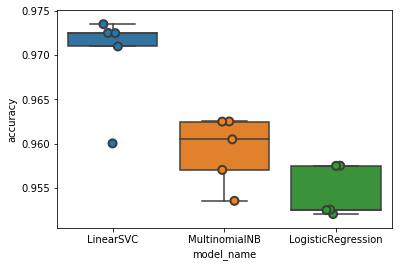

In [83]:
# Plot out the results

import seaborn as sns
sns.boxplot(x = 'model_name', y = 'accuracy', data = cv_df_accuracy)
sns.stripplot(x = 'model_name', y = 'accuracy', data = cv_df_accuracy, 
              size = 8, jitter = True, edgecolor = "gray", linewidth = 2)
plt.show()

The results above tell us that every model perfomed very well for our data, being able to achieve a mean accuracy more than 95%. However, one thing that worth notice is that our data is highly imbalanced, with 93% observatiosn falling into the negative category. That is to say, even the classifier classify all our observation as 0.0, it is still able to achieve an accuracy of 93%. Therefore, accuracy alone is not reliable in our case. <br>

Then I changed the metric to precision instead as it is more focused in the positive class than in the negative class. It measures the probability of correct detection of positive values, which is also our focus.

In [84]:
# Use precision instead

entries_precision = []
for model in models:
    model_name = model.__class__.__name__
    precisions = cross_val_score(model, features, labels, scoring = 'precision', cv = CV)
    for fold_idx, precision in enumerate(precisions):
        entries_precision.append((model_name, fold_idx, precision))
cv_df_precision = pd.DataFrame(entries_precision, columns = ['model_name', 'fold_idx', 'precision'])
cv_df_precision

,model_name,fold_idx,precision
0,LinearSVC,0,0.718750
1,LinearSVC,1,0.909091
2,LinearSVC,2,0.895238
3,LinearSVC,3,0.925532
4,LinearSVC,4,0.913978
5,MultinomialNB,0,0.736264
6,MultinomialNB,1,0.890625
7,MultinomialNB,2,0.906667
8,MultinomialNB,3,0.968750
9,MultinomialNB,4,0.951613


In [85]:
# Mean precision for each model

cv_df_precision.groupby('model_name').precision.mean()

model_name
LinearSVC             0.872518
LogisticRegression    0.911230
MultinomialNB         0.890784
Name: precision, dtype: float64

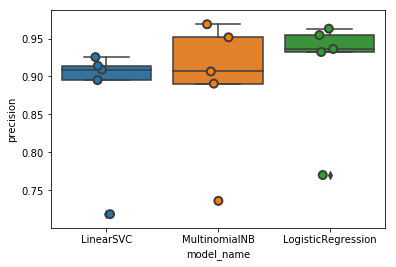

In [86]:
# Plot out the results

sns.boxplot(x = 'model_name', y = 'precision', data = cv_df_precision)
sns.stripplot(x = 'model_name', y = 'precision', data = cv_df_precision, 
              size = 8, jitter = True, edgecolor = "gray", linewidth = 2)
plt.show()

Since Logistics Regression has the highest precision, I chose it as my final model and trained it with the whole dataset. <br>

At last, I made predictions based on the trained model.

In [87]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(random_state = 0)),
])
text_clf_whole = text_clf.fit(data['ItemDescription'][: 10000], data['PreventiveFlag'][: 10000])

In [88]:
# Predict with probability

predicted_prob = text_clf.predict_proba(data['ItemDescription'][10000:])
predicted_prob

array([[0.97208512, 0.02791488],
       [0.96329326, 0.03670674],
       [0.98768429, 0.01231571],
       ...,
       [0.92431392, 0.07568608],
       [0.98380972, 0.01619028],
       [0.97882529, 0.02117471]])

In [89]:
prediction = pd.DataFrame({'Prob of Non-flag': predicted_prob[:, 0],'Prob of Flag': predicted_prob[:, 1]})
predicted_id = range(10001, 11001)
prediction['Predicted_id'] = predicted_id
prediction = prediction[['Predicted_id', 'Prob of Non-flag', 'Prob of Flag']]
prediction.head()

,Predicted_id,Prob of Non-flag,Prob of Flag
0,10001,0.972085,0.027915
1,10002,0.963293,0.036707
2,10003,0.987684,0.012316
3,10004,0.978864,0.021136
4,10005,0.997743,0.002257


## Conclusion

For this problem, I built a text classifier based on Logistic Regression and predicted with probablities for our unlabeled data. The features were extracted from the original text data, using Bag of Words and TF-IDF. I used precision as my model selection metric and chose the best model among Navie Bayes, Linear Support Vector Machin and Logistic Regression. <br>

However, this doesn't necessarily indicate the end of the analysis of this data. There are several things we can try in the future to achieve a better result. For example, we can try to diversify our training corpus or have a more balanced data; more data pre-processing like stemming can be done to improve our feature quality; hyper-parameter tuning can help us to find a better model.